# Fresh and Stale Images of Fruits and Vegetables Classification

---

The used dataset contains images of 6 fruits and vegetables: ***apple, banana, bitter gourd, capsicum, orange, and tomato***. The images of each fruit or vegetable are grouped into two categories: fresh and stale. The purpose behind the creation of this dataset is the development of a machine learning model to classify fruits and vegetables as fresh or stale. The dataset can be downloaded at https://www.kaggle.com/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

Here I developed 2 architectural models, namely **CCN from Scratch** and **VGG16 + CNN with Transfer Learning**. From the training results obtained the following accuracy:

<center>
  <b>Table 1. Comparison between Models</b>
</center>

| Model | Tran Acc. (%) | Validation Acc. (%) | Time |
|-------|---------------|---------------------|------|
|CNN | 85.90  | 89.43  | 13m 46s |
|VGG16 + CNN | 90.25  | 91.74  | 13m 48s |


### TF-Lite Model Filename

- Model CCN from Scratch: ```best_model-cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002.h5.tflite```
- Model VGG16 + CNN with Transfer Learning: ```best_model-vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002.h5.tflite```

In [1]:
# install library needed
!pip install -q kaggle
!pip install split_folders
!pip install awesome-slugify

     |████████████████████████████████| 235kB 9.8MB/s 
  Created wheel for awesome-slugify: filename=awesome_slugify-1.6.5-cp37-none-any.whl size=8352 sha256=39e45dd00b35b2ad1beb5288ae9bfa68afaae357a6ecccb7f36a5f2c3ada63cb
  Stored in directory: /root/.cache/pip/wheels/e9/d9/66/bde66382496710218c0df31b5f3a72bd8079bcd275fff61b29
Successfully built awesome-slugify


In [135]:
# import library needed
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import layers, Model
from keras.applications.vgg16 import VGG16

from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import cv2
import numpy as np
import pandas as pd

import os
import time
import uuid
import glob
import warnings
import splitfolders
from tqdm import tqdm
from IPython.display import Markdown, display
from slugify import slugify

In [3]:
# Ignore the unwanted warning messages
warnings.filterwarnings('ignore')

In [133]:
# Define base path for worksheet
BASE_PATH = '/content/drive/MyDrive/Playground/Fresh and Stale'
# Size of input images
IMAGE_HEIGHT=224
IMAGE_WIDTH=224
# No. of class
NUM_CLASS=12
# No. of images to be yielded from the generator per batch
BATCH_SIZE=32
# Set the dropout
DROPOUT=0.2
# Learning rate
LEARNING_RATE=0.001
# Number of iterations
EPOCH=50

In [5]:
# Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

### Data Gathering

In [6]:
# upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imamkusniadi","key":"30fa97395ea7d3c066e0aff94a241f54"}'}

In [7]:
# make directory and change permission
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json && ls ~/.kaggle

kaggle.json


In [8]:
# download the dataset
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

 99% 1.40G/1.41G [00:16<00:00, 95.1MB/s]
100% 1.41G/1.41G [00:17<00:00, 88.9MB/s]


In [12]:
!unzip fresh-and-stale-images-of-fruits-and-vegetables.zip -d /content/drive/MyDrive/Playground/Fresh\ and\ Stale/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.09 PM.png  
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.15 PM.png  
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.24 PM.png  
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.32 PM.png  
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.38 PM.png  
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.21 PM.png  
  inflating: /content/drive/MyDrive/Playground/Fresh and Stale/dataset/stale_banana/rotated_by_15_Scree

In [14]:
# remove downloaded dataset
!rm -rf fresh-and-stale-images-of-fruits-and-vegetables.zip

### Data Exploration

In [50]:
# Check total of data and sampling data
def count_data_sampling(path):
  images = []
  count_path = 0
  for dir in os.listdir(path):
    count_sub = 0
    sub = glob.glob(os.path.join(path, dir) + '/*')
    for file in sub:
      if count_sub < 1:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append([image, dir])

      count_sub += 1
      count_path += 1

    print("{} : {}".format(dir, count_sub))

  print("\nTotal data : {}".format(count_path))
  print("Sample images : \n")

  rows = 3
  plt.figure(figsize=(15,15))
  for i in range(9):
      plt.subplot(rows,3,i+1)
      plt.title("Sample {} image".format(images[i][1]))
      plt.imshow(images[i][0])

fresh_apple : 1693
fresh_banana : 1581
fresh_bitter_gourd : 327
fresh_capsicum : 990
fresh_orange : 1466
fresh_tomato : 981
stale_apple : 2342
stale_banana : 1467
stale_bitter_gourd : 357
stale_capsicum : 901
stale_orange : 1595
stale_tomato : 982

Total data : 14682
Sample images : 



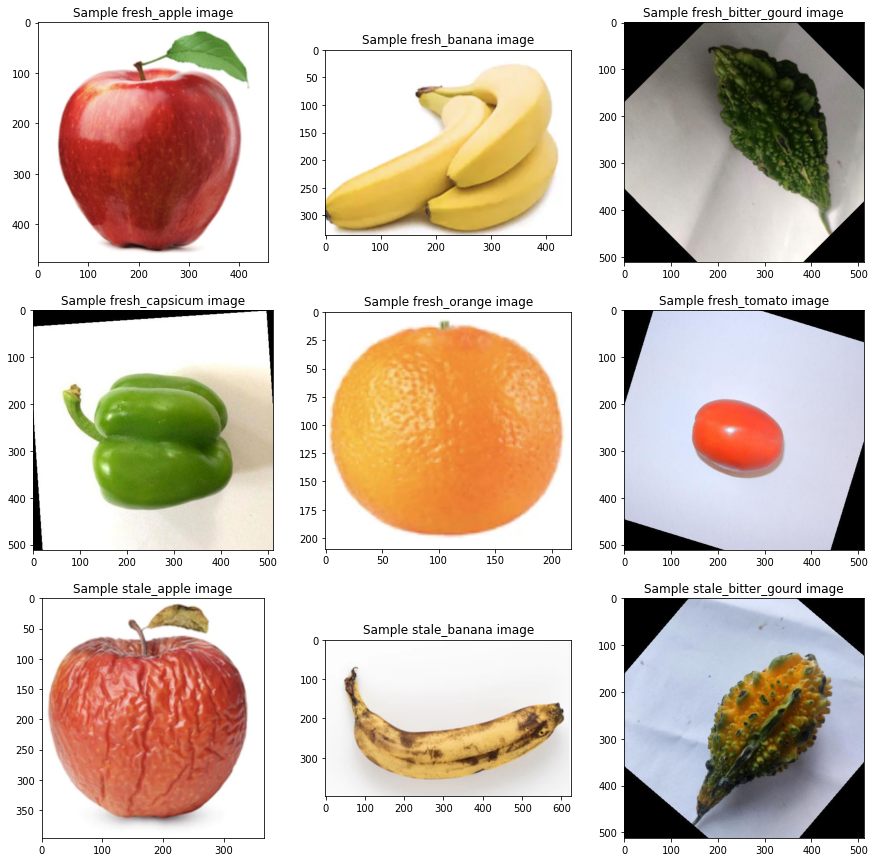

In [51]:
# Set dataset path
DATASET_PATH = os.path.join(BASE_PATH, 'dataset')
# Check total dataset every label
count_data_sampling(DATASET_PATH)

### Data Spliting

In [52]:
# Split dataset with 8:2 ratio 
SPLIT_PATH = os.path.join(BASE_PATH, 'split')
splitfolders.ratio(
    os.path.join(DATASET_PATH), 
    os.path.join(SPLIT_PATH), 
    seed=1, 
    ratio=(.8, .2)
)

Copying files: 14682 files [03:23, 72.22 files/s]


In [59]:
# Check total of data
def count_data(path):
  count_path = 0
  for dir in os.listdir(path):
    count_sub = 0
    sub = glob.glob(os.path.join(path, dir) + '/*')
    for file in sub:
      count_sub += 1
      count_path += 1

    print("{} : {}".format(dir, count_sub))

  print("\nTotal data : {}".format(count_path))

In [55]:
# Set dataset path
TRAIN_PATH = os.path.join(SPLIT_PATH, 'train')
VALIDATION_PATH = os.path.join(SPLIT_PATH, 'val')

In [60]:
# Check total train data
count_data(TRAIN_PATH)

fresh_apple : 1354
fresh_banana : 1264
fresh_bitter_gourd : 261
fresh_capsicum : 792
fresh_orange : 1172
fresh_tomato : 784
stale_apple : 1873
stale_banana : 1173
stale_bitter_gourd : 285
stale_capsicum : 720
stale_orange : 1276
stale_tomato : 785

Total data : 11739


In [61]:
# Check total validation data
count_data(VALIDATION_PATH)

fresh_apple : 339
fresh_banana : 317
fresh_bitter_gourd : 66
fresh_capsicum : 198
fresh_orange : 294
fresh_tomato : 197
stale_apple : 469
stale_banana : 294
stale_bitter_gourd : 72
stale_capsicum : 181
stale_orange : 319
stale_tomato : 197

Total data : 2943


In [62]:
# Remove unsplited dataset to make more free space
!rm -rf /content/drive/MyDrive/Playground/Fresh\ and\ Stale/dataset/*

### Data Augmentation

In [63]:
train_data_generator = ImageDataGenerator(
  rescale=1./255,
  rotation_range=45,
  width_shift_range=.15,
  height_shift_range=.15,
  shear_range=.2,
  zoom_range=.2,
  horizontal_flip=True)

validation_data_generator = ImageDataGenerator(rescale=1./255)

In [64]:
train_generator = train_data_generator.flow_from_directory(
  TRAIN_PATH,
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  class_mode='categorical',
  shuffle = True,
  seed=42)

validation_generator = validation_data_generator.flow_from_directory(
  VALIDATION_PATH,
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  class_mode='categorical',
  shuffle = True,
  seed=42)

Found 11739 images belonging to 12 classes.
Found 2943 images belonging to 12 classes.


In [65]:
sample_train_images, _ = next(train_generator)
sample_validation_images, _ = next(validation_generator)

In [66]:
# Plot image
def plot_image(images):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image, pl in zip(images, axes):
    pl.imshow(image)
    pl.axis('off')

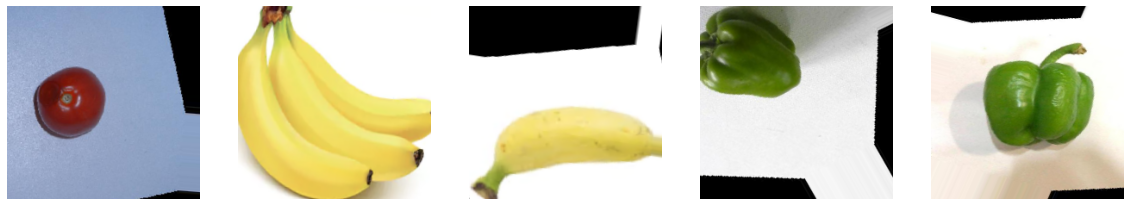

In [67]:
# show sample image of train data after data augmentation
plot_image(sample_train_images)

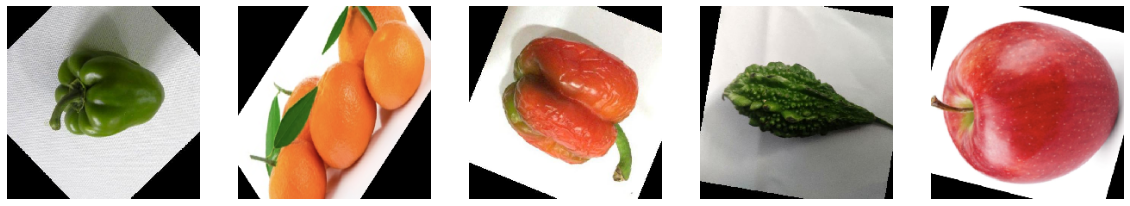

In [68]:
# show sample image of validation data after data augmentation
plot_image(sample_validation_images)

## Model

### Simple CNN from Scratch

In [136]:
def CNN():
  model = Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ))
  model.add(layers.Conv2D(32, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2, 2))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
                         activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006),
                         activation='relu'))
  model.add(layers.Dropout(rate=DROPOUT))
  model.add(layers.Dense(NUM_CLASS, activation='softmax'))

  optimizer = Adam(LEARNING_RATE)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [137]:
# Visualize simple CNN model
CNN().summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 112, 112, 8)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 8)       32        
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 110, 110, 32)      2336      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 26, 26, 64)      

### VGG16 + CNN Transfer Learning

In [ ]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [138]:
def VGGCNN():
  input_tensor = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  vgg16 = VGG16(
      weights='imagenet',
      include_top=False,
      input_tensor=input_tensor
  )
  
  # Make CNN layers not trainable / Freezing Convolutional layers
  # Don't train existing weights, because the weights are ready fix
  for layer in vgg16.layers:
      layer.trainable = False
        
  # Defreeze all batch normalization layers due to a bug in transfer learning using keras
  for layer in vgg16.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
  
  cnn = Sequential()
  cnn.add(layers.Flatten(input_shape=vgg16.output_shape[1:]))
  cnn.add(layers.Dense(512, activation='relu'))
  cnn.add(layers.Dropout(0.5))
  cnn.add(layers.Dense(NUM_CLASS, activation='softmax'))

  model = Model(vgg16.input, cnn(vgg16.output))

  optimizer = Adam(LEARNING_RATE)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [139]:
# Visualize custom VGG16+CNN transfer learning model
VGGCNN().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Traing

### Utility & Helper

In [109]:
# Set target names/label
target_names = ['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato', 
                'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato']

# Print in markdown format
def printmd(string):
    display(Markdown(string))

# Plot training loss and accuracy
def plot_training(history, title, save=True, save_path=os.path.join(BASE_PATH, 'visualization')):
    printmd("### Plot Training Loss and Accuracy")
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_list = range(1, len(acc) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc=0, fontsize='large')
    plt.xlabel("Epoch #", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.show()
    
    if save is True:
        filename = slugify(title) + '_loss_model.png'
        plt.savefig(save_path + '/' + filename)

    plt.figure(figsize=(8, 6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc=4, fontsize='large')
    plt.xlabel("Epoch #", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()
    
    if save is True:
        filename = slugify(title) + '_acc_model.png'
        plt.savefig(save_path + '/' + filename)

# Plot confusion matrix
def plot_confusion_matrix(classes, preds, title, save=True, save_path=os.path.join(BASE_PATH, 'visualization')):
    printmd('#### Confusion Matrix')
    cm = confusion_matrix(classes, preds)
    print('True Positive (TP):', cm[0][0])
    print('False Positive (FP):', cm[0][1])
    print('False Negative (FN):', cm[1][0])
    print('True Negative (TN):', cm[1][1])
    df_cm = pd.DataFrame(cm, range(len(target_names)), range(len(target_names)))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, fmt=".0f", annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(len(target_names)))
    plt.yticks(np.arange(len(target_names)))
    plt.ylim([len(target_names), 0])
    
    if save is True:
        filename = slugify(title) + '_confusion_matrix.png'
        plt.savefig(save_path + '/' + filename)

    plt.show()
    
    # Calculate accuracy
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy:", calculated_acc*100)

# Table classification report
def table_classification_report(classes, preds):
    printmd('#### Classification Report')
    print(classification_report(classes, preds, target_names=target_names))

    print('Accuracy: {:.2f}\n'.format(accuracy_score(classes, preds)))

    print('Macro Precision: {:.2f}'.format(precision_score(classes, preds, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(classes, preds, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(classes, preds, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(classes, preds, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(classes, preds, average='weighted')))
    print('Weighted F1-score: {:.2f}\n'.format(f1_score(classes, preds, average='weighted')))

# Evaluate model, confusion matrix and classification report
def model_evaluation(title, model, train_generator, validation_generator, save=True, save_path=os.path.join(BASE_PATH, 'visualization')):
    printmd('### Training Accuracy')
    loss, val_acc = model.evaluate_generator(train_generator, verbose=1)

    print("loss: %.2f" % (loss*100))
    print("acc: %.2f" % (val_acc*100))
    
    printmd('### Validation Accuracy')
    loss, val_acc = model.evaluate_generator(validation_generator, verbose=1)

    print("loss: %.2f" % (loss*100))
    print("acc: %.2f" % (val_acc*100))
    
    printmd('### Evaluation of Model Performance')
    Y_pred = model.predict_generator(validation_generator, verbose=1)
    y_pred = np.argmax(Y_pred, axis=1)
    x_pred = validation_generator.classes
    
    # Plot confusion matrix
    plot_confusion_matrix(x_pred, y_pred, title, save, save_path)
    
    # Table classification report
    table_classification_report(x_pred, y_pred)

### Training using CNN Model

In [129]:
# Adding callbacks
train_id = 'cnn-' + str(uuid.uuid1())
best_model = os.path.join(BASE_PATH, 'model/best_model-' + train_id + '.h5')
last_model = os.path.join(BASE_PATH, 'model/last_model-' + train_id + '.h5')
csv_log = os.path.join(BASE_PATH, 'monitor/logs-' + train_id + '.h5')

ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
MC = ModelCheckpoint(best_model, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
CSVL = CSVLogger(csv_log, separator=",", append=True)

callbacks = [MC, ES, CSVL]

In [130]:
# Training start time
start_time = time.time()

print("Training strated with Train ID: {}".format(train_id))

model = CNN()
history = model.fit_generator(train_generator, 
                    steps_per_epoch=25, 
                    epochs=EPOCH, 
                    validation_data=validation_generator,
                    validation_steps=5,
                    verbose=1,
                    callbacks=callbacks)

# Training complete
time_elapsed = time.time() - start_time
# Save last model
model.save(last_model)

print("=" * 30)
print("Training Finished, took {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
print("Best model:", best_model)
print("Last model:", last_model)

Training strated with Train ID: cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002
Epoch 1/50
25/25 [==============================] - 17s 526ms/step - loss: 8.0130 - accuracy: 0.2235 - val_loss: 4.2446 - val_accuracy: 0.1437

Epoch 00001: val_accuracy improved from -inf to 0.14375, saving model to /content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002.h5
Epoch 2/50
25/25 [==============================] - 13s 501ms/step - loss: 3.0203 - accuracy: 0.5070 - val_loss: 2.8921 - val_accuracy: 0.3000

Epoch 00002: val_accuracy improved from 0.14375 to 0.30000, saving model to /content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002.h5
Epoch 3/50
25/25 [==============================] - 12s 500ms/step - loss: 2.1253 - accuracy: 0.5447 - val_loss: 2.4506 - val_accuracy: 0.3375

Epoch 00003: val_accuracy improved from 0.30000 to 0.33750, saving model to /content/drive/MyDrive/Playground/Fresh and Stal

### Plot Training Loss and Accuracy

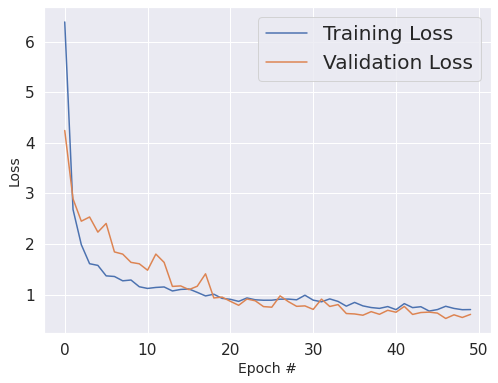

<Figure size 432x288 with 0 Axes>

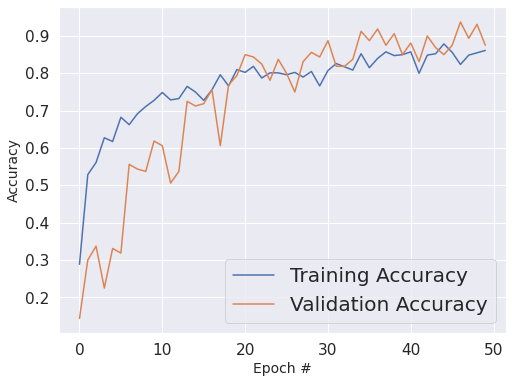

<Figure size 432x288 with 0 Axes>

In [131]:
# Plot training and loss accuracy
plot_training(history, train_id)

Load best model to evaluate ...


### Training Accuracy

367/367 [==============================] - 161s 438ms/step - loss: 0.6973 - accuracy: 0.8590
loss: 69.73
acc: 85.90


### Validation Accuracy

92/92 [==============================] - 15s 162ms/step - loss: 0.6212 - accuracy: 0.8943
loss: 62.12
acc: 89.43


### Evaluation of Model Performance

92/92 [==============================] - 15s 160ms/step


#### Confusion Matrix

True Positive (TP): 35
False Positive (FP): 35
False Negative (FN): 36
True Negative (TN): 37


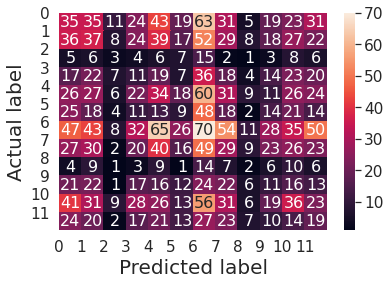

Calculated Accuracy: 50.349650349650354


#### Classification Report

                    precision    recall  f1-score   support

       fresh_apple       0.11      0.10      0.11       339
      fresh_banana       0.12      0.12      0.12       317
fresh_bitter_gourd       0.05      0.05      0.05        66
    fresh_capsicum       0.05      0.06      0.05       198
      fresh_orange       0.10      0.12      0.11       294
      fresh_tomato       0.06      0.05      0.05       197
       stale_apple       0.14      0.15      0.14       469
      stale_banana       0.10      0.10      0.10       294
stale_bitter_gourd       0.03      0.03      0.03        72
    stale_capsicum       0.06      0.06      0.06       181
      stale_orange       0.14      0.11      0.12       319
      stale_tomato       0.08      0.10      0.08       197

          accuracy                           0.10      2943
         macro avg       0.09      0.09      0.09      2943
      weighted avg       0.10      0.10      0.10      2943

Accuracy: 0.10

Macro Precision: 0.09

In [132]:
# Load best model and evaluate
print("Load best model to evaluate ...")
model = load_model(best_model)
model_evaluation(train_id, model, train_generator, validation_generator)

In [141]:
# Writing code to save the model into TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_save_path = best_model + '.tflite'

print("Save path and name:", tflite_save_path)

try:
  with tf.io.gfile.GFile(tflite_save_path, 'wb') as f:
    f.write(tflite_model)

  print("Saving into TF-Lite file successfully ...")
except Exception as e:
  print("Saving into TF-Lite file error: {}".format(e))

INFO:tensorflow:Assets written to: /tmp/tmpm66hyb8w/assets


INFO:tensorflow:Assets written to: /tmp/tmpm66hyb8w/assets


Save path and name: /content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002.h5.tflite
Saving into TF-Lite file successfully ...


### Training using VGG16 + CNN Model Transfer Learning

In [143]:
# Adding callbacks
train_id = 'vgg16-' + str(uuid.uuid1())
best_model = os.path.join(BASE_PATH, 'model/best_model-' + train_id + '.h5')
last_model = os.path.join(BASE_PATH, 'model/last_model-' + train_id + '.h5')
csv_log = os.path.join(BASE_PATH, 'monitor/logs-' + train_id + '.h5')

ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
MC = ModelCheckpoint(best_model, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
CSVL = CSVLogger(csv_log, separator=",", append=True)

callbacks = [MC, ES, CSVL]

In [145]:
# Training start time
start_time = time.time()

print("Training strated with Train ID: {}".format(train_id))

model = VGGCNN()
history = model.fit_generator(train_generator, 
                    steps_per_epoch=25, 
                    epochs=EPOCH, 
                    validation_data=validation_generator,
                    validation_steps=5,
                    verbose=1,
                    callbacks=callbacks)

# Training complete
time_elapsed = time.time() - start_time
# Save last model
model.save(last_model)

print("=" * 30)
print("Training Finished, took {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
print("Best model:", best_model)
print("Last model:", last_model)

Training strated with Train ID: vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002
Epoch 1/50
25/25 [==============================] - 16s 571ms/step - loss: 5.3497 - accuracy: 0.1800 - val_loss: 1.2744 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to /content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002.h5
Epoch 2/50
25/25 [==============================] - 14s 557ms/step - loss: 1.5520 - accuracy: 0.4471 - val_loss: 0.8013 - val_accuracy: 0.7125

Epoch 00002: val_accuracy improved from 0.53125 to 0.71250, saving model to /content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002.h5
Epoch 3/50
25/25 [==============================] - 14s 561ms/step - loss: 1.2998 - accuracy: 0.5113 - val_loss: 0.9993 - val_accuracy: 0.5813

Epoch 00003: val_accuracy did not improve from 0.71250
Epoch 4/50
25/25 [==============================] - 13s 536ms/s

### Plot Training Loss and Accuracy

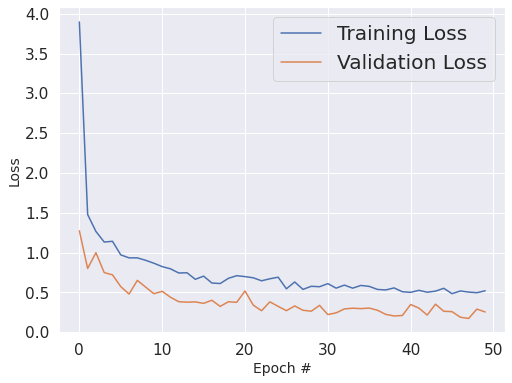

<Figure size 432x288 with 0 Axes>

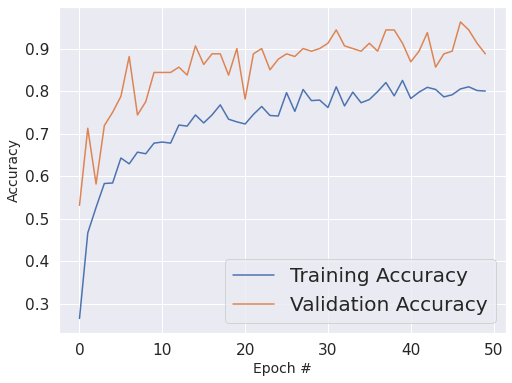

<Figure size 432x288 with 0 Axes>

In [146]:
# Plot training and loss accuracy
plot_training(history, train_id)

Load best model to evaluate ...


### Training Accuracy

367/367 [==============================] - 178s 483ms/step - loss: 0.2761 - accuracy: 0.9025
loss: 27.61
acc: 90.25


### Validation Accuracy

92/92 [==============================] - 24s 259ms/step - loss: 0.2330 - accuracy: 0.9174
loss: 23.30
acc: 91.74


### Evaluation of Model Performance

92/92 [==============================] - 18s 195ms/step


#### Confusion Matrix

True Positive (TP): 31
False Positive (FP): 39
False Negative (FN): 32
True Negative (TN): 41


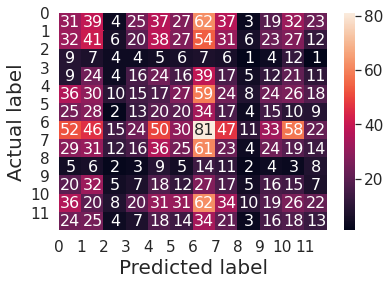

Calculated Accuracy: 50.349650349650354


#### Classification Report

                    precision    recall  f1-score   support

       fresh_apple       0.10      0.09      0.10       339
      fresh_banana       0.12      0.13      0.13       317
fresh_bitter_gourd       0.05      0.06      0.06        66
    fresh_capsicum       0.09      0.08      0.09       198
      fresh_orange       0.06      0.06      0.06       294
      fresh_tomato       0.08      0.10      0.09       197
       stale_apple       0.15      0.17      0.16       469
      stale_banana       0.08      0.08      0.08       294
stale_bitter_gourd       0.03      0.03      0.03        72
    stale_capsicum       0.08      0.09      0.08       181
      stale_orange       0.10      0.08      0.09       319
      stale_tomato       0.08      0.07      0.07       197

          accuracy                           0.10      2943
         macro avg       0.09      0.09      0.09      2943
      weighted avg       0.10      0.10      0.10      2943

Accuracy: 0.10

Macro Precision: 0.09

In [147]:
# Load best model
print("Load best model to evaluate ...")
model = load_model(best_model)
model_evaluation(train_id, model, train_generator, validation_generator)

In [148]:
# Writing code to save the model into TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_save_path = best_model + '.tflite'

print("Save path and name:", tflite_save_path)

try:
  with tf.io.gfile.GFile(tflite_save_path, 'wb') as f:
    f.write(tflite_model)

  print("Saving into TF-Lite file successfully ...")
except Exception as e:
  print("Saving into TF-Lite file error: {}".format(e))

INFO:tensorflow:Assets written to: /tmp/tmpn_ovis4w/assets


INFO:tensorflow:Assets written to: /tmp/tmpn_ovis4w/assets


Save path and name: /content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002.h5.tflite
Saving into TF-Lite file successfully ...


## Prediction

In [149]:
def prediction(model_path):
  # Load model
  model = load_model(model_path)
  # Start uploading
  upload = files.upload()
  for path in upload.keys():
    # predicting uploaded image
    img = image.load_img(path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=BATCH_SIZE)

    # define text labels
    food_labels = ['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato', 
                   'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato']
    
    # get detection label
    idx = np.argmax(classes[0])
    label = food_labels[idx]
    # get prediction percentage/similarities
    similarities = classes[0,idx]*100

    # ploting the image
    plt.title("Prediction : {} ({:.2f}%)".format(label, similarities))
    plt.imshow(img)

In [150]:
# List available model
# Model using CNN from Scratch
cnn_best_model = '/content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002.h5'
cnn_last_model = '/content/drive/MyDrive/Playground/Fresh and Stale/model/last_model-cnn-d9373038-e2d4-11eb-acbf-0242ac1c0002.h5'
# Model using VGG16 + CNN Transfer Learning
vgg16_best_model = '/content/drive/MyDrive/Playground/Fresh and Stale/model/best_model-vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002.h5'
vgg16_last_model = '/content/drive/MyDrive/Playground/Fresh and Stale/model/last_model-vgg16-d0f03484-e2d8-11eb-acbf-0242ac1c0002.h5'

Saving 61fZ+YAYGaL._SL1500_.jpg to 61fZ+YAYGaL._SL1500_ (2).jpg


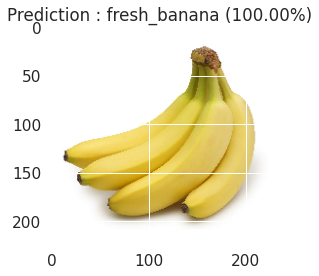

In [154]:
# Make prediction, show upload page to predict using CNN from Scratch
prediction(model_path=cnn_best_model)

Saving 71TIrDaZNnL._SX679_.jpg to 71TIrDaZNnL._SX679_.jpg


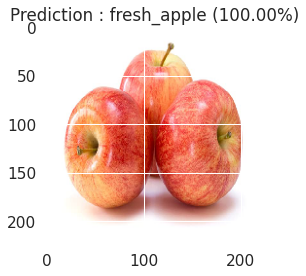

In [155]:
# Make prediction, show upload page to predict using CNN from Scratch
prediction(model_path=cnn_best_model)